In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules

In [11]:
class AlexNet(nn.Module) : 
    def __init__(self, number_of_classes):
        super(AlexNet, self).__init__()
        self.convnet = nn.Sequential(

            nn.Conv2d(3, 96, 11, 4, 0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d((3, 3), 2),

            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, k=2), 
            nn.MaxPool2d((3, 3), 2), 

            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(), 

            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(), 

            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), 2)
        )

        self.fcnet = nn.Sequential(

            nn.Dropout(0.5), 
            nn.Linear(6*6*256, 4096), ## 이전에 maxpooling을 했기 대문에 6x6으로 바뀜
            nn.ReLU(), 

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(), 

            nn.Linear(4096, number_of_classes)
        )
    
    def forward(self, x):
        x = self.convnet(x)
        x = torch.flatten(x, 1)
        x = self.fcnet(x)
        return x

alexnet = AlexNet(1000)
print(alexnet)

AlexNet(
  (convnet): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fcnet): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=Tru

In [10]:
import os
import torch.optim as optim 
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms 
import numpy as np

import time
import copy 
import matplotlib.pyplot as plt

In [19]:
ddir = 'hymenoptera_data'

data_transformers = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ]), 
    'val' : transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ])
}

img_data = {
    k : datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']
}
dloaders = {
    k : torch.utils.data.DataLoader(img_data[k], batch_size = 8, shuffle = True, num_workers=2) for k in ['train', 'val']
}

dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes
dvc = torch.device('cpu')


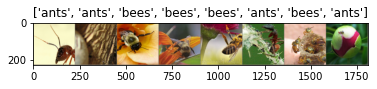

In [21]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None : 
        plt.title(text)

imgs, cls = next(iter(dloaders['train']))
grid = torchvision.utils.make_grid(imgs)
imageshow(grid, text = [classes[c] for c in cls])
class_success = list(0. for i in range(10))

In [23]:
def finetune_model(pretrained_model, loss_func, optim, epochs=10):
    ''''''
    start = time.time()
    model_weights = copy.deepcopy(pretrained_model.state_dict())
    accuracy = 0.

    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)
        for dset in ['train', 'val']:
            if dset == 'train':
                pretrained_model.train()
            else : 
                pretrained_model.eval()
            
            loss = 0. 
            successes = 0

            for imgs, tgts in dloaders[dset] : 

                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optim.zero_grad()
                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)

                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()
                loss += loss_curr.item() * imgs.size(0) ## 배치로 들어가니 배치 크기 만큼 곱해줌
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]

            if dset == 'val' and accuracy_epoch > accuracy : 
                accuracy = accuracy_epoch
                model_weights = copy.deepcopy(pretrained_model.state_dict())
    
    pretrained_model.load_state_dict(model_weights)
    return pretrained_model



In [24]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training ## ?? 
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            tgts = tgts.to(dvc)

            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)

            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs // 2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target : {classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs : 
                    pretrained_model.train(mode=was_model_training)
                    return 
        pretrained_model.train(mode=was_model_training)

In [25]:
model_finetune = models.alexnet(pretrained=True)

c:\Users\handy\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\handy\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\handy/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:20<00:00, 11.9MB/s] 


In [28]:
print(model_finetune.features) ## 합성곱, 풀링 계층
print(model_finetune.classifier) ## fully connected layer 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True

In [31]:
## 오..! 지금 데이터셋에 맞게 아키텍처 변경 !!!!!
model_finetune.classifier[6] = nn.Linear(4096, len(classes))